# UKF 

In [1]:
import numpy as np
import scipy.linalg
import argparse
import sys
import os
import time
import matplotlib.pyplot as plt

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    logRdt = theta[:, 0] * rabbit - theta[:, 1] * rabbit * fox
    logFdt = theta[:, 2] * rabbit * fox - theta[:, 3] * fox
    return np.stack([logRdt, logFdt], axis=1)

def find_all_sigma_points(x_bar, x_var, alpha=1e-3, kappa=0, beta=2):
    l_dim_x = len(x_bar)
    lambda_scaling = alpha**2 * (l_dim_x + kappa) - l_dim_x
    eigval, eigmat = np.linalg.eig((l_dim_x + lambda_scaling) * x_var)
    matsqrt = eigmat @ np.diag(np.sqrt(eigval)) @ eigmat.transpose()
    sigma_points = np.block([
        [x_bar],
        [x_bar + matsqrt],
        [x_bar - matsqrt]])
    weight_m = np.ones(2*l_dim_x+1) / (2 * (l_dim_x + lambda_scaling))
    weight_m[0] = lambda_scaling / (l_dim_x + lambda_scaling)
    weight_c = np.copy(weight_m)
    weight_c[0] = lambda_scaling / (l_dim_x + lambda_scaling) + (1 - alpha**2 + beta)
    return dict(sigma_points=sigma_points, weight_m=weight_m, weight_c=weight_c)

ukf_ls = np.zeros((100, 240, 12))

days = 20
obs_per_day = 12
time_ls = np.zeros(100)
for EachRep in range(100):
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('LV observations.npy')[EachRep]
    ydata = yobs.copy()
    tvecObs = np.arange(0, days, 1/obs_per_day)
    tvecFull = np.arange(0, days, 1 / obs_per_day)
    yFull = ydata.copy()
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])
        
        
    noise = 0.2
    dim_x = 2
    dim_theta = 4
    prior_mean_x_theta_u_e = np.array([yFull[0, 0], yFull[0, 1], 0.6, 0.75, 1., 1.,0,0,0,0,0,0])
    prior_variance_x_theta = np.diag([noise ** 2, noise ** 2, 1, 1, 1, 1])
    variance_u_unit_time = np.diag([0.1, 0.01, 0.01, 0.1])
    prior_variance_e = np.diag([noise ** 2, noise ** 2])

    estimate_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x])
    variance_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x, dim_x + dim_theta + dim_theta + dim_x])

    estimate_x_theta_u_e[0] = prior_mean_x_theta_u_e
    variance_x_theta_u_e[0] = scipy.linalg.block_diag(prior_variance_x_theta, variance_u_unit_time, prior_variance_e)
    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]
        variance_x_theta_u_e[k-1][(dim_x + dim_theta):(dim_x + 2 * dim_theta), (dim_x + dim_theta):(dim_x + 2 * dim_theta)] *= delta_t

        unscented_info = find_all_sigma_points(estimate_x_theta_u_e[k-1], variance_x_theta_u_e[k-1])

        sigma_points_pred_theta = unscented_info['sigma_points'][:, dim_x:(dim_x+dim_theta)] + unscented_info['sigma_points'][:, (dim_x+dim_theta):(dim_x+2*dim_theta)]
        sigma_points_previous_x = unscented_info['sigma_points'][:, :dim_x]
        sigma_points_pred_x = sigma_points_previous_x + delta_t * fOde(sigma_points_pred_theta, sigma_points_previous_x)

        mean_pred_x = np.sum(sigma_points_pred_x * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        mean_pred_theta = np.sum(sigma_points_pred_theta * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

        mean_pred_x_theta = np.concatenate([mean_pred_x, mean_pred_theta])
        sigma_points_pred_x_theta = np.block([sigma_points_pred_x, sigma_points_pred_theta])
        var_pred_x_theta = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_x_theta.shape[0]):
            residual = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
            var_pred_x_theta += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])

        sigma_points_pred_u_e =  unscented_info['sigma_points'][:, (dim_x+dim_theta):]
        mean_pred_u_e = np.sum(sigma_points_pred_u_e * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred_u_e = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_u_e.shape[0]):
            residual = sigma_points_pred_u_e[i, :] - mean_pred_u_e
            var_pred_u_e += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])
        sigma_points_pred = np.block([sigma_points_pred_x_theta, sigma_points_pred_u_e])
        mean_pred = np.sum(sigma_points_pred * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred = np.zeros([2 * (dim_x + dim_theta), 2 * (dim_x + dim_theta)])
        for i in range(sigma_points_pred.shape[0]):
            residual = sigma_points_pred[i, :] - mean_pred
            var_pred += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])


        if not np.any(np.isfinite(yFull[k, :])):
            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
        else:
            yobs = yFull[k, :]
            sigma_points_pred_y = sigma_points_pred_x + unscented_info['sigma_points'][:, (dim_x + 2 * dim_theta):]
            mean_pred_y = np.sum(sigma_points_pred_y * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

            var_pred_y = np.zeros([dim_x, dim_x])
            cov_pred_xtheta_y = np.zeros([dim_x + dim_theta, dim_x])
            for i in range(sigma_points_pred_y.shape[0]):
                residual_y = sigma_points_pred_y[i, :] - mean_pred_y
                residual_xtheta = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
                var_pred_y += unscented_info['weight_c'][i] * residual_y.reshape([-1, 1]) @ residual_y.reshape([1, -1])
                cov_pred_xtheta_y += unscented_info['weight_c'][i] * residual_xtheta.reshape([-1, 1]) @ residual_y.reshape([1, -1])

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            mean_pred_y = mean_pred_y[idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            mean_pred_x_theta = mean_pred_x_theta + cov_pred_xtheta_y @ invvar_pred_y @ (yobs - mean_pred_y)
            var_pred_x_theta = var_pred_x_theta - cov_pred_xtheta_y @ invvar_pred_y @ cov_pred_xtheta_y.transpose()

            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
    ukf_ls[EachRep] = estimate_x_theta_u_e
    time_ls[EachRep] = time.time() - start_time

print(np.mean(time_ls), np.std(time_ls))

0.25470002174377443 0.010046361466460015


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


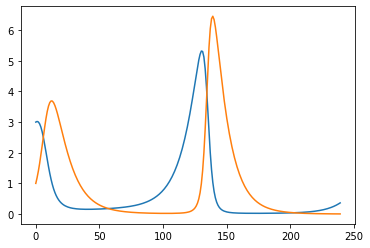

In [2]:
all_alpha = ukf_ls[:, :, 2]
all_beta = ukf_ls[:, :, 3]
all_delta = ukf_ls[:, :, 4]
all_gamma = ukf_ls[:, :, 5]

days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./obs_per_day)
true_alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
true_beta = 0.75 * np.ones(nobs)
true_delta = np.ones(nobs)
true_gamma = 1 + 0.1 * np.sin(6.28 * X / 10)

def recover_data(alpha, beta, delta, gamma, state0=[3., 1.], days=20, obs_per_day=12, linspace=1000):
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.zeros((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha[index] * state_ls[i - 1][0] - beta[index] * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta[index] * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]

    return states

true_x = recover_data(true_alpha, true_beta, true_delta, true_gamma)
plt.plot(true_x[:, 0])
plt.plot(true_x[:, 1])

all_reconstructed_x = np.zeros((100, 240, 2))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_alpha[i], all_beta[i], all_delta[i], all_gamma[i], state0=[3., 1.])

Text(0.5, 1.2, 'Results of UKF across 100 simulations')

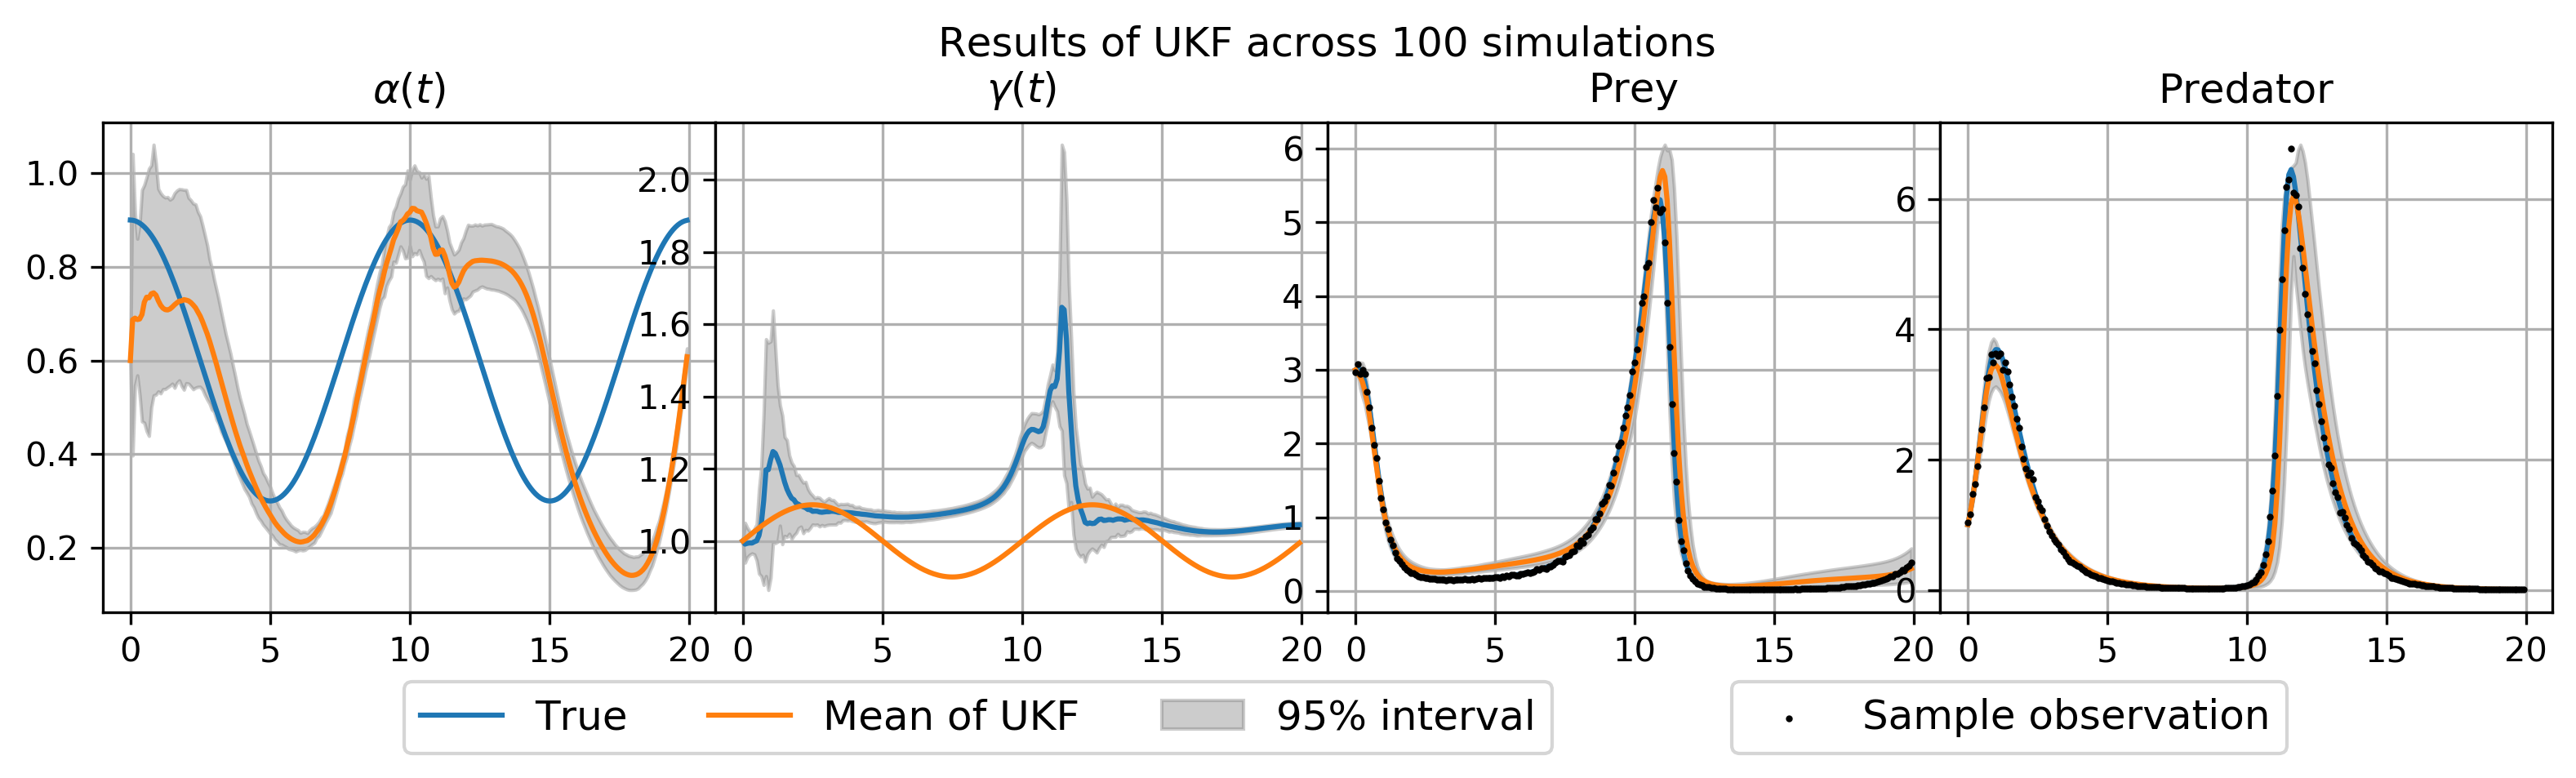

In [3]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # set figsize
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_alpha, 97.5, axis=0)
upper_95 = np.percentile(all_alpha, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_alpha, label='True')
plt.plot(x, np.mean(all_alpha, axis=0), label='Mean of UKF')
plt.title(r'$\alpha(t)$')
plt.grid()
plt.legend(bbox_to_anchor=(2.4, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_gamma, 97.5, axis=0)
upper_95 = np.percentile(all_gamma, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_gamma, axis=0))
plt.plot(x, true_gamma)
plt.grid()
plt.title(r'$\gamma(t)$')

yobs = np.load('G:/TVMAGI-LV/LV observations.npy')[1]
ax1 = plt.subplot(1, 4, 3) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 20, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 0])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Prey')
plt.legend(bbox_to_anchor=(1.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Predator')
plt.suptitle('Results of UKF across 100 simulations', y=1.2)

# RMSE

In [4]:
RMSE_alpha = np.sqrt(np.mean(np.square(all_alpha - true_alpha), axis=0))
print(np.mean(RMSE_alpha), np.std(RMSE_alpha))
RMSE_beta = np.abs(all_beta - true_beta)
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_delta = np.abs(all_delta - true_delta)
print(np.mean(RMSE_delta), np.std(RMSE_delta))
RMSE_gamma = np.sqrt(np.mean(np.square(all_gamma - true_gamma), axis=0))
print(np.mean(RMSE_gamma), np.std(RMSE_gamma))

0.2062697291952275 0.15963573065433023
0.07482001838812456 0.040360142303404775
0.026304967455648177 0.03088458994045777
0.1191412641577782 0.09903430577725558


In [5]:
RMSE_R = np.zeros(100)
RMSE_F = np.zeros(100)
for i in range(100):
    RMSE_R[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 0] - true_x[:, 0])))
    RMSE_F[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 1] - true_x[:, 1])))
    
print(np.mean(RMSE_R), np.std(RMSE_R))
print(np.mean(RMSE_F), np.std(RMSE_F))

0.2715858116813561 0.10641154005575298
0.3164568276623074 0.1419904902267455
